<h1>Assignment 3</h1>

<h2>Due: Tue 28 Jan 2020 Midnight</h2>
<a href='http://www.cs.bgu.ac.il/~elhadad/nlp21.html'>Natural Language Processing - Fall 2021 Michael Elhadad</a>
<p/>
This assignment covers the topic of syntactic parsing.
Submit your solution in the form of a Jupyter notebook (ipynb) file.

<h2>Content</h2>
<ul>
<li><a href="#q1">Q1: Designing CFGs for NLP</a></li>
    <ul>
        <li><a href="#q1.1">Q1.1: Extend a CFG to support Number agreement, Pronouns and Dative Constructions</a>
            <ul>
                <li><a href="#q1.1.1">Q1.1.1 Determiners and Count/Mass Nouns</a></li>
                <li><a href="#q1.1.2">Q1.1.2 Pronouns</a></li>
                <li><a href="#q1.1.3">Q1.1.3 Subject/Verb Agreement</a></li>
                <li><a href="#q1.1.4">Q1.1.4 Over-generation</a></li>
            </ul>            
        </li>
        <li><a href="#q1.2">Q1.2: Extend a CFG to support Coordination and Prepositional Phrases</a>
            <ul>
                <li><a href="#q1.2.1">Q1.2.1 Support Prepositional Phrases</a></li>
                <li><a href="#q1.2.2">Q1.2.2 Support Coordination</a></li>
                <li><a href="#q1.2.3">Q1.2.3 Over-generation</a></li>
            </ul>            
        </li>
    </ul>
</li>
<li><a href="#q2">Q2: Learning a PCFG from a Treebank</a>
    <ul>
        <li><a href="#q2.1">Q2.1 Random PCFG Generation</a>
            <ul>
                <li><a href="#q2.1.1">Q2.1.1 PCFG_Generate</a></li>
                <li><a href="#q2.1.2">Q2.1.2 Generate 1,000 Trees</a></li>
                <li><a href="#q2.1.3">Q2.1.3 Gather Rules Frequency for all Non-Terminals</a></li>
                <li><a href="#q2.1.4">Q2.1.4 Compute KL-Divergence between a priori and generated parameters</a></li>
            </ul>
        </li>
        <li><a href="#q2.2">Q2.2 Learn a PCFG from a Treebank</a>
            <ul>
                <li><a href="#q2.2.1">Q2.2.1 Induce_PCFG</a></li>
                <li><a href="#q2.2.2">Q2.2.2 Data Exploration</a></li>
            </ul>
        </li>
        <li><a href="#q2.3">Q2.3 Induce a PCFG in Chomsky Normal Form</a>
            <ul>
                <li><a href="#q2.3.1">Q2.3.1 PCFG_CNF_Learn</a></li>
                <li><a href="#q2.3.2">Q2.3.2 Data Exploration</a></li>
            </ul>
        </li>
        <li><a href="#q2.4">Q2.4 Test CFG Independence Assumptions</a></li>
    </ul>
</li>
<li><a href="#q3">Q3: Building and Evaluating a Simple PCFG Parser</a>
	<ul>
        <li><a href="#q3.1">Q3.1 Build a Parser</a>
            <ul>
                <li><a href="#q3.1.1">Q3.1.1 Dataset Split</a></li>
                <li><a href="#q3.1.2">Q3.1.2 Learn a PCFG over the Chomsky Normal Form</a></li>
                <li><a href="#q3.1.3">Q3.1.3 Viterbi Parser</a></li>
            </ul>            
        </li>
        <li><a href="#q3.2">Q3.2 Evaluate the Parser</a></li>
        <li><a href="#q3.3">Q3.3 Accuracy per Distance</a></li>
        <li><a href="#q3.4">Q3.4 Accuracy per Label</a></li>
    </ul>
</li>
</ul>

<hr/>
<a name="q1"></a>
<h2>Question 1: Designing CFGs for NLP</h2>

NLTK provides library support to read CFGs from string representation, and parse sentences given a CFG using different 
parsing algorithms (either top-down or bottom-up).  In this question, we manually develop a grammar to support 
increasingly complex phenomena in English syntax. The following code provides the starting point:

In [1]:
import nltk
from nltk import CFG

sg = """
S -> NP VP
VP -> IV | TV NP
NP -> 'John' | "bread"
IV -> 'left'
TV -> 'eats'
"""
g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

# Parse sentences and observe the behavior of the parser
def parse_sentence(sent,parser):
    tokens = sent.split()
    sr_parser = parser
    trees = sr_parser.parse(tokens)
    for tree in trees:
        print(tree)


In this toy grammar, the following non-terminals are used:  
`S`: sentence 

`VP`: verb phrase

`NP`: noun phrase

`IV`: intransitive verb (a verb that does not expect a complement)

Let's try our grammar with 2 simple sentences:


In [2]:
parse_sentence("John left", sr_parser)
print()
parse_sentence("John eats bread",sr_parser)

Parsing 'John left'
    [ * John left]
  S [ 'John' * left]
  R [ NP * left]
  S [ NP 'left' * ]
  R [ NP IV * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (IV left)))

Parsing 'John eats bread'
    [ * John eats bread]
  S [ 'John' * eats bread]
  R [ NP * eats bread]
  S [ NP 'eats' * bread]
  R [ NP TV * bread]
  S [ NP TV 'bread' * ]
  R [ NP TV NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (TV eats) (NP bread)))


## Q1.1 ##

We successfully parsed the sentences. But these are very simple, what if we want to deal with more complicated sentences?
To do that, we will have to expand our grammer. We would like to parse these sentences:



In [3]:
input_sentences = '''John left
John loves Mary
They love Mary
They love her
She loves them
Everybody loves John
A boy loves Mary
The boy loves Mary
Some boys love Mary
John gave Mary a heavy book
John gave it to Mary
John likes butter
John moves a chair'''

    
First, we must add new phrasal categories: 

`DV` - ditransitive verb (such as `give`). It will allow us to distinguish between verbs that take different numbers of NPs. 

`PP` - prepositional phrase

`Det` - Determiner

`Adj` - Adjective

`P` - prepositional

Using our old and new phrasal categories, we can create grammer that can parse the sentences above.

In [4]:
exp_sg = """
S -> NP VP
VP ->    TV NP | DV NP NP|  DV NP PP| |TV NP PP|  IV 
NP -> Det NP | Adj NP | N 
PP -> P NP
Adj -> "heavy"
Det -> "The" | "A" | "a" | "Some"
N -> 'John' | "bread" | "They" | "She" | "Everybody" | "boy" | "Mary" | "book" | "it" | "chair" | "butter" | "her" | "them" | "boys"
P -> "to"
IV -> 'left'
TV -> 'eats' | "love" | "loves" | "moves" | "likes" 
DV -> 'gave'  
"""

exp_g = CFG.fromstring(exp_sg)

# Bottom-up  parser
exp_sr_parser = nltk.ShiftReduceParser(exp_g, trace=2)

for sentence in input_sentences.split("\n"):
    parse_sentence(sentence, exp_sr_parser)

Parsing 'John left'
    [ * John left]
  S [ 'John' * left]
  R [ N * left]
  R [ NP * left]
  S [ NP 'left' * ]
  R [ NP IV * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP (N John)) (VP (IV left)))
Parsing 'John loves Mary'
    [ * John loves Mary]
  S [ 'John' * loves Mary]
  R [ N * loves Mary]
  R [ NP * loves Mary]
  S [ NP 'loves' * Mary]
  R [ NP TV * Mary]
  S [ NP TV 'Mary' * ]
  R [ NP TV N * ]
  R [ NP TV NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP (N John)) (VP (TV loves) (NP (N Mary))))
Parsing 'They love Mary'
    [ * They love Mary]
  S [ 'They' * love Mary]
  R [ N * love Mary]
  R [ NP * love Mary]
  S [ NP 'love' * Mary]
  R [ NP TV * Mary]
  S [ NP TV 'Mary' * ]
  R [ NP TV N * ]
  R [ NP TV NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP (N They)) (VP (TV love) (NP (N Mary))))
Parsing 'They love her'
    [ * They love her]
  S [ 'They' * love her]
  R [ N * love her]
  R [ NP * love her]
  S [ NP 'love' * her]
  R [ NP TV * her]
  S [ NP TV 'her' * ]
  R [ NP TV N * ]
  R [ NP TV NP

## 1.1.1 Determiners and Count/Mass Nouns

Determiners in English come before common nouns. Proper nouns cannot have a determiner. (We ignore cases such as "The Petersons came by tonight for a visit.")
Some determiners can only be used for singular nouns ("a"), others only for plural nouns ("many") and others with either plural or singular ("the").

Some common nouns are called "uncountable" or [mass nouns](https://en.wikipedia.org/wiki/Mass_noun) (e.g., "butter"). Mass nouns cannot appear in plural and cannot have counting determiners. Other nouns are [countable nouns](https://en.wikipedia.org/wiki/Count_noun%22). They can be used in the plural and can be modified by counting determiners.

Let's try to expand our grammar in order to make it sensitive to these different rules.
For that, we will add some general NTs, and split our terminals into different categories:
`PDet` = Plural Det   
`SDet` =  Singular Det   
`CN` = Common Noun  
`ProperN` = Proper Noun  
`CCN` = Countable Common Noun   
`MCN` = Mass Common Noun  
`PCCN` =  Plural `CCN`  
`SCCN` = Singular `CCN`  


In [23]:


exp2_sg = """
S    ->   NP VP
VP   ->   TV NP | DV NP NP | DV NP PP | TV NP PP | IV 
NP   ->   PDet PCCN | SDet SCCN | Det Adj NP | Det NP | N
PP   ->   P NP  
N    ->   CN | ProperN                    
CN   ->   CCN | MCN                  
CCN  ->   PCCN | SCCN   
Det  ->   PDet | SDet |"The"             
Adj  ->   "heavy"
ProperN   ->   "John" | "Mary" |  "They" | "She" | "Everybody" |  "her" | "them" | "it" 
MCN  ->   "butter" 
PCCN ->   "boys"
SCCN ->   "book" | "bread" |  "boy" | "chair" 
PDet ->   "Some"
SDet ->   "A" | "a" 
P    ->   "to" 
IV   ->   "left" 
TV   ->   "eats" | "love" | "loves" | "moves" | "likes" 
DV   ->   "gave"  
"""

exp2_g = CFG.fromstring(exp2_sg)

exp2_sr_parser = nltk.ShiftReduceParser(exp2_g, trace=1)
print(input_sentences)
for sentence in input_sentences.split("\n"):
    print()
    print('parsing', '"'+sentence+'"', "...")
    parse_sentence(sentence, exp2_sr_parser)

John left
John loves Mary
They love Mary
They love her
She loves them
Everybody loves John
A boy loves Mary
The boy loves Mary
Some boys love Mary
John gave Mary a heavy book
John gave it to Mary
John likes butter
John moves a chair

parsing "John left" ...
Parsing 'John left'
    [ * John left]
    [ 'John' * left]
    [ NP 'left' * ]
(S (NP (N (ProperN John))) (VP (IV left)))

parsing "John loves Mary" ...
Parsing 'John loves Mary'
    [ * John loves Mary]
    [ 'John' * loves Mary]
    [ NP 'loves' * Mary]
    [ NP TV 'Mary' * ]
(S (NP (N (ProperN John))) (VP (TV loves) (NP (N (ProperN Mary)))))

parsing "They love Mary" ...
Parsing 'They love Mary'
    [ * They love Mary]
    [ 'They' * love Mary]
    [ NP 'love' * Mary]
    [ NP TV 'Mary' * ]
(S (NP (N (ProperN They))) (VP (TV love) (NP (N (ProperN Mary)))))

parsing "They love her" ...
Parsing 'They love her'
    [ * They love her]
    [ 'They' * love her]
    [ NP 'love' * her]
    [ NP TV 'her' * ]
(S (NP (N (ProperN They))) (V

## 1.1.2-3 Pronouns and Subject/Verb Agreement

Pronouns in English are characterized by the following morphological attributes:
Number: singular / plural (e.g., he/they)
Gender: masculine / feminine / neutral (e.g., he/she/it)
Case: nominative / accusative (e.g., he/him)

For example, Let's have a look on the following sentences:
    He loves Mary
    They love Mary
There is an agreement between the Noun and the Verb regarding the suffix 's' after the verb. We want to represent this difference and to allow verb terminals with suffix 's' only third-person-singular (3rd. pers. sing.) 
We could keep splitting the NT to smaller one. but holding NT for any attribute of a noun, for example, is not very attractive:  
`Nomi_Singular_Pro_Noun -> "he" `

`Nomi_Plural_Pro_Noun -> "they" `

As nltk's book [explains](https://www.nltk.org/book/ch09.html#ex-good1):

*In place of a single production expanding S, we now have two productions, one covering the sentences involving singular subject NPs and VPs, the other covering sentences with plural subject NPs and VPs. In fact, every production in (5) has two counterparts in (6). With a small grammar, this is not really such a problem, although it is aesthetically unappealing. However, with a larger grammar that covers a reasonable subset of English constructions, the prospect of doubling the grammar size is very unattractive. Let's suppose now that we used the same approach to deal with first, second and third person agreement, for both singular and plural. This would lead to the original grammar being multiplied by a factor of 6, which we definitely want to avoid.*

Instead we can use **features** - it will make our code cleaner and easier to understand.
Our features will include `NUM` for singular / plural, and `CASE` - for nominative / accusative. We won't have to hold information regarding gender - the agreement in our sentences doesn't require that since English verbs don't need to agree about gender. It is varying between languages - CFG for Hebrew, Arabic or French must do so. 



In [6]:
from nltk import grammar, parse

g = """S ->  NP[NUM=?n , CASE="nom"] VP[NUM=?n] 
VP[NUM=?n] -> IV[NUM=?n] | TV[NUM=?n] NP | TV[NUM=?n] NP PP | DV[NUM=?n] NP PP | DV[NUM=?n] NP NP
DET ->  "The" | DET[NUM="sg", COUNT = "yes" ] | DET[NUM="Pl", COUNT = "yes" ]
PP -> "to" | PP NP
NP[NUM=?n] -> ProN[NUM=?n] |DET[NUM=?n, CASE =?c] NP[NUM=?n , CASE=?c] |  DET[NUM=?n, CASE =?c] ADJ NP[NUM=?n, CASE =?c] |PropN[NUM=?n] | N
ADJ -> "heavy"
PropN[NUM="sg"] -> "John" | "Mary"
ProN[NUM="sg",CASE="acc"] -> "her" | "it"
ProN[NUM="pl",CASE="acc"] -> "them"
ProN[NUM="sg",CASE="nom"] -> "She" |"Everybody"
ProN[NUM="pl",CASE="nom"] -> "They"
DET[NUM="sg", COUNT = "yes" ] ->  "a" | "A" 
DET[NUM="Pl", COUNT = "yes" ] ->  "Some" 
N[NUM="sg", COUNT = "yes" ] ->  "boy" | "chair" | "book"
N[NUM="pl", COUNT = "yes" ] ->  "boys"
N[COUNT = "no"] -> "butter"
IV[NUM="sg"]   ->   "left"
TV[NUM="sg"]   ->   "eats" | "loves" | "moves" | "likes" 
TV[NUM="pl"]   ->   "love" 
DV   ->   "gave"  """

gmr =  grammar.FeatureGrammar.fromstring(g)
parser = parse.FeatureEarleyChartParser(gmr , trace = 0 )

from nltk.tree import Tree
from IPython.display import display

    
def features_parse_sentence(sent):
    print("trying to parse the sentence...")
    tokens = sent.split()
    trees = parser.parse(tokens)
    found = False
    for tree in trees:
        found = True
        print(tree)
        print()
        break
    if not found: print("Couldn't parse a legal tree!")    
      
for sentence in input_sentences.split("\n"):
    print('parsing','"'+sentence+'":' )
    features_parse_sentence(sentence)

parsing "John left":
trying to parse the sentence...
(S[]
  (NP[NUM='sg'] (PropN[NUM='sg'] John))
  (VP[NUM='sg'] (IV[NUM='sg'] left)))

parsing "John loves Mary":
trying to parse the sentence...
(S[]
  (NP[NUM='sg'] (PropN[NUM='sg'] John))
  (VP[NUM='sg']
    (TV[NUM='sg'] loves)
    (NP[NUM='sg'] (PropN[NUM='sg'] Mary))))

parsing "They love Mary":
trying to parse the sentence...
(S[]
  (NP[NUM='pl'] (ProN[CASE='nom', NUM='pl'] They))
  (VP[NUM='pl']
    (TV[NUM='pl'] love)
    (NP[NUM='sg'] (PropN[NUM='sg'] Mary))))

parsing "They love her":
trying to parse the sentence...
(S[]
  (NP[NUM='pl'] (ProN[CASE='nom', NUM='pl'] They))
  (VP[NUM='pl']
    (TV[NUM='pl'] love)
    (NP[NUM='sg'] (ProN[CASE='acc', NUM='sg'] her))))

parsing "She loves them":
trying to parse the sentence...
(S[]
  (NP[NUM='sg'] (ProN[CASE='nom', NUM='sg'] She))
  (VP[NUM='sg']
    (TV[NUM='sg'] loves)
    (NP[NUM='pl'] (ProN[CASE='acc', NUM='pl'] them))))

parsing "Everybody loves John":
trying to parse the sent

## 1.1.4 Over-generation

Since we build are CFG to handle specific sentences, we must be aware of over generation.
While we do try to distinguish between different features of the different POS, natural languages are complicated, include exceptional cases, and change all the time. Trying to cover every sentence mught lead to numerous of NTs and rules. 
Let's check our grammer, to see where it fails.

Let's first make sure it doesn't parse mistakes of wrong `NUM`.
We will take off the *s* from a verb of singular noun, or add it for plural noun:

In [7]:
features_parse_sentence("John love it")
features_parse_sentence("They loves her")

trying to parse the sentence...
Couldn't parse a legal tree!
trying to parse the sentence...
Couldn't parse a legal tree!


And how about using accusative in nominative's place?

In [8]:
features_parse_sentence("them loves her")

trying to parse the sentence...
Couldn't parse a legal tree!


Great! Our grammer didn't allow these mistakes, but what if take away the count determiner?

In [9]:
features_parse_sentence("John moves chair") 

trying to parse the sentence...
(S[]
  (NP[NUM='sg'] (PropN[NUM='sg'] John))
  (VP[NUM='sg']
    (TV[NUM='sg'] moves)
    (NP[NUM=?n] (N[COUNT='yes', NUM='sg'] chair))))



Here it fails. Let's it with some more examples:

In [10]:
features_parse_sentence("John moves chair to They")

trying to parse the sentence...
(S[]
  (NP[NUM='sg'] (PropN[NUM='sg'] John))
  (VP[NUM='sg']
    (TV[NUM='sg'] moves)
    (NP[NUM=?n] (N[COUNT='yes', NUM='sg'] chair))
    (PP[] (PP[] to) (NP[NUM='pl'] (ProN[CASE='nom', NUM='pl'] They)))))



In [11]:
features_parse_sentence("They love boy to chair")

trying to parse the sentence...
(S[]
  (NP[NUM='pl'] (ProN[CASE='nom', NUM='pl'] They))
  (VP[NUM='pl']
    (TV[NUM='pl'] love)
    (NP[NUM=?n] (N[COUNT='yes', NUM='sg'] boy))
    (PP[] (PP[] to) (NP[NUM=?n] (N[COUNT='yes', NUM='sg'] chair)))))



In [12]:
features_parse_sentence("Mary loves butter to butter")

trying to parse the sentence...
(S[]
  (NP[NUM='sg'] (PropN[NUM='sg'] Mary))
  (VP[NUM='sg']
    (TV[NUM='sg'] loves)
    (NP[NUM=?n] (N[COUNT='no'] butter))
    (PP[] (PP[] to) (NP[NUM=?n] (N[COUNT='no'] butter)))))



Well... It is far from being perfect!

We will try to improve it in the next quetions.

# Q1.2.

## 1.2.1 Support Prepositional Phrases

Prepositional phrases allow us to better describe nouns, verbs or adjectives. They help us to add more information. Infact, we can add infinite numbers of prepositional phrase, each one adds extra detail:

* *I saw a dog.*

* *I saw a dog on the grass.*

* *I saw a dog on the grass with black fur.*

* *I saw a dog on the grass with black fur near the table.*

* *I saw a dog on the grass with black fur near the table with the drinks.*

...

In addition, we would like to extend  are grammer so it can parse coordinations. Coordinations add the ability to use words such as "and" or "or". These words will always come between phrases from the same kind.
For example - 

* *i ate (NP pizza) and (NP salad)*

* *Yesterday I (VP ran) and (VP ate)*

But it can not coordinates phrases of different types:

* *I (VP ate) and (NP pizza)*

It can coordinate infinite number of phrases as well, as long as they have the same POS:

* *Avi ate (VP pizza) and (VP falafel) and (VP salad) and (VP hummus)...*  

Avi must have been really hungry! Let's try to add this abilities to our CFG. 


In [13]:
from nltk import grammar, parse
import re
g = """S ->  NP[NUM=?n , CASE="nom"] VP[NUM=?n] 
VP[NUM=?n] -> IV[NUM=?n] | TV[NUM=?n] NP | TV[NUM=?n] NP PP | DV[NUM=?n] NP PP | DV[NUM=?n] NP NP
DET ->  "The" | "the" | DET[NUM="sg", COUNT = "yes" ] | DET[NUM="Pl", COUNT = "yes" ]
PP -> P NP | P NP PP  
NP[NUM=?n] -> ProN[NUM=?n] |DET[NUM=?n, CASE =?c] NP[NUM=?n , CASE=?c] |  DET[NUM=?n, CASE =?c] ADJ NP[NUM=?n, CASE =?c] |PropN[NUM=?n] | NP NP |NP CON NP | N
P[] -> "with" | "on" | "to"
ADJ[] -> "heavy"
CON[] -> "and"
PropN[NUM="sg"] -> "John" | "Mary"
ProN[NUM="sg",CASE="acc"] -> "her" | "it"
ProN[NUM="pl",CASE="acc"] -> "them"
ProN[NUM="sg",CASE="nom"] -> "She" |"Everybody"
ProN[NUM="pl",CASE="nom"] -> "They"
DET[NUM="sg", COUNT = "yes" ] ->  "a" | "A" 
DET[NUM="Pl", COUNT = "yes" ] ->  "Some" 
N[NUM="sg", COUNT = "yes" ] ->  "boy" | "chair" | "book" | "man" | "telescope" | "hill" 
N[NUM="pl", COUNT = "yes" ] ->  "boys" | "men" | "women" | "children"
N[COUNT = "no"] -> "butter" | "bread" | "cheese" | "mac"
IV[]  ->   "left"
TV[NUM="sg"]   ->   "eats" | "loves" | "moves" | "likes" | "shows" | "knows"
TV[NUM="pl"]   ->   "love" | "eat"
TV[]   ->   "saw"
DV   ->   "gave"  """

g =  grammar.FeatureGrammar.fromstring(g)
parser = parse.FeatureEarleyChartParser(g , trace = 0 )
input_co_sentences = '''John saw a man with a telescope
John saw a man on the hill with a telescope
Mary knows men and women
Mary knows men, children and women
John and Mary eat bread
John and Mary eat bread with cheese'''      
for sentence in input_co_sentences.split("\n"):
    print('parsing','"'+sentence+'":' )
    features_parse_sentence(re.sub(",","", sentence))

parsing "John saw a man with a telescope":
trying to parse the sentence...
(S[]
  (NP[NUM='sg'] (PropN[NUM='sg'] John))
  (VP[NUM=?n]
    (TV[] saw)
    (NP[NUM=?n]
      (DET[] (DET[COUNT='yes', NUM='sg'] a))
      (NP[NUM=?n] (N[COUNT='yes', NUM='sg'] man)))
    (PP[]
      (P[] with)
      (NP[NUM=?n]
        (DET[] (DET[COUNT='yes', NUM='sg'] a))
        (NP[NUM=?n] (N[COUNT='yes', NUM='sg'] telescope))))))

parsing "John saw a man on the hill with a telescope":
trying to parse the sentence...
(S[]
  (NP[NUM='sg'] (PropN[NUM='sg'] John))
  (VP[NUM=?n]
    (TV[] saw)
    (NP[NUM=?n]
      (DET[] (DET[COUNT='yes', NUM='sg'] a))
      (NP[NUM=?n] (N[COUNT='yes', NUM='sg'] man)))
    (PP[]
      (P[] on)
      (NP[NUM=?n]
        (DET[] the)
        (NP[NUM=?n] (N[COUNT='yes', NUM='sg'] hill)))
      (PP[]
        (P[] with)
        (NP[NUM=?n]
          (DET[] (DET[COUNT='yes', NUM='sg'] a))
          (NP[NUM=?n] (N[COUNT='yes', NUM='sg'] telescope)))))))

parsing "Mary knows men and 

# 1.2.2 Support Coordination

Coordination phrase has its own number, and it is not always easy to decide it. Let's have a look on two sentences:

*Deni and Yovel play in Maccabi Tel-Aviv Basketball team*

*Deni or Yovel is practicing as we speak*

So knowing that we have a coordination is not enough in order to decide the number. Without knowing it we won't be able to make sure the verb agrees, and therefore we must hold this information somehow.
We could have just mark `and` as plural and `or` as singular, but it is not that simple:

* *Yovel or the rest of the team play every week* 

It seems that plural `NP` affect the whole coordination and change the following verb accordingly. The plural case is "stronger" than the singular case. We will need to consider that when trying to decide how to use the verb.
what else should we consider? Let's have a look at another sentence: 


* *Mac and cheese is his favorite food*

"mac and cheese", in this case, represents singular noun, even though we see using in `and`. Of course, it might also be two different meals - and in this case we will consider it as plural `NP`. So sometime we have ambiguity that depends on culture, knowledge, context etc.

We suggest the following rules in order to decide the number of a coordination NP (it can be more general, but we split it into cases to allow extension):  
Let X be a coordination of the pattern (**and** (NP1,NP2)).  
if NP1 is singular/mass and NP2 is singular/mass:  
&emsp;if X surrounded by quotation mark or X is an item in the lexicon :  
&emsp;&emsp; X's number is singular  
&emsp;else:    
&emsp;&emsp;X's number is plural  
else if NP1 is singular/mass and NP2 is plural (or the other way around):  
&emsp;if X surrounded by quotation mark or X is an item in the lexicon :  
&emsp;&emsp;X's number is singular  
&emsp;else:  
&emsp;&emsp;X's number is plural  
else if NP1 is plural and NP2 is plural:  
&emsp;if X surrounded by quotation mark or X is an item in the lexicon :  
&emsp;&emsp;X's number is singular  
&emsp;else:  
&emsp;&emsp;X's number is plural  
        
          
Let Y be a coordination of the pattern (**or** (NP1,NP2)).  
if NP1 is singular/mass and NP2 is singular/mass:  
&emsp;Y's number is singular  
else if NP1 is singular/mass and NP2 is plural (or the other way around):  
&emsp;Y's number is plural  
else if else if NP1 is plural and NP2 is plural:  
&emsp;Y's number is plural  

These rules will help us generate trees which hopefully will be as accurate as possible, but languages not always follow simple rules. There are lots of exceptions, knowledge-based changes, and of course - changes as time pass.


# 1.2.3 Overgeneration

As we add more rules, we overgenerate our grammer, allowing more and more incorrect sentences to be parsed.
We do support coordination, but as we showed before, and since we don't have lexicon we use, we will parse the following example:

In [14]:
# semantics error 
features_parse_sentence("book and chair love it")

trying to parse the sentence...
(S[]
  (NP[NUM=?n]
    (NP[NUM=?n] (N[COUNT='yes', NUM='sg'] book))
    (CON[] and)
    (NP[NUM=?n] (N[COUNT='yes', NUM='sg'] chair)))
  (VP[NUM='pl']
    (TV[NUM='pl'] love)
    (NP[NUM='sg'] (ProN[CASE='acc', NUM='sg'] it))))



In [15]:
# syntactic error
features_parse_sentence("boys and men loves it")

trying to parse the sentence...
(S[]
  (NP[NUM=?n]
    (NP[NUM=?n] (N[COUNT='yes', NUM='pl'] boys))
    (CON[] and)
    (NP[NUM=?n] (N[COUNT='yes', NUM='pl'] men)))
  (VP[NUM='sg']
    (TV[NUM='sg'] loves)
    (NP[NUM='sg'] (ProN[CASE='acc', NUM='sg'] it))))



In [16]:
features_parse_sentence("chair and men and boys and telescope and They and them loves it")

trying to parse the sentence...
(S[]
  (NP[NUM=?n]
    (NP[NUM=?n]
      (NP[NUM=?n]
        (NP[NUM=?n]
          (NP[NUM=?n]
            (NP[NUM=?n] (N[COUNT='yes', NUM='sg'] chair))
            (CON[] and)
            (NP[NUM=?n] (N[COUNT='yes', NUM='pl'] men)))
          (CON[] and)
          (NP[NUM=?n] (N[COUNT='yes', NUM='pl'] boys)))
        (CON[] and)
        (NP[NUM=?n] (N[COUNT='yes', NUM='sg'] telescope)))
      (CON[] and)
      (NP[NUM='pl'] (ProN[CASE='nom', NUM='pl'] They)))
    (CON[] and)
    (NP[NUM='pl'] (ProN[CASE='acc', NUM='pl'] them)))
  (VP[NUM='sg']
    (TV[NUM='sg'] loves)
    (NP[NUM='sg'] (ProN[CASE='acc', NUM='sg'] it))))



<hr/>
<a name="q2"></a>
<h2>Question 2: Learning a PCFG from a Treebank</h2>

<a name="q2.1"></a>
<h3>Question 2.1: Random PCFG Generation</h3>

Consider the PCFG datatype implementation provided in NLTK.
<p/>
Consider the module <a href="http://www.nltk.org/_modules/nltk/parse/generate.html">nltk.parse.generate</a>.
It contains a function generate(grammar) which given a CFG grammar produces all the sentences the grammar can produce.
Naturally, this may produce an infinite number of sentences if the grammar is recursive.

In [158]:
                        import itertools
from nltk.grammar import CFG
from nltk.parse import generate

demo_grammar = """
  S -> NP VP
  NP -> Det N
  PP -> P NP
  VP -> 'slept' | 'saw' NP | 'walked' PP
  Det -> 'the' | 'a'
  N -> 'man' | 'park' | 'dog'
  P -> 'in' | 'with'
"""
grammar = CFG.fromstring(demo_grammar)

for n, sent in enumerate(generate.generate(grammar, n=10), 1):
        print('%3d. %s' % (n, ' '.join(sent)))

  1. the man slept
  2. the man saw the man
  3. the man saw the park
  4. the man saw the dog
  5. the man saw a man
  6. the man saw a park
  7. the man saw a dog
  8. the man walked in the man
  9. the man walked in the park
 10. the man walked in the dog


<a name="q2.1.1"></a>
<h4>2.1.1 PCFG_Generate</h4>

Write a new function <code>pcfg_generate(grammar)</code> which will
generate a random tree from a PCFG according to its generative
probability model.  In other words, your task is to write a <code>sample</code>
method from the PCFG distribution.
<p/>

Generation works top down: pick the start symbol of
the grammar, then randomly choose a production starting from the start
symbol, and add the RHS as children of the root node, then expand each
node until you obtain terminals.  The result should be a tree and not
a sentence.
<p/>

The generated parse trees should exhibit the distribution of non-terminal
distributions captured in the PCFG (that is, the generation process should
sample rules according to the weights of each non-terminal in the grammar).
<p/>

Note: you must generate according to the PCFG distribution - not just randomly.
To this end, you should use the method <code>generate()</code> from the
NTLK <a href="http://www.nltk.org/_modules/nltk/probability.html">ProbDistI</a> interface.
Specifically, you should use the
<a href="http://www.nltk.org/api/nltk.html#nltk.probability.DictionaryProbDist">nltk.probability.DictionaryProbDist</a>
class to represent the probability distribution of mapping an LHS non-terminal to one of the possible RHS.

<pre class="prettyprint">
Function Specification

pcfg_generate(grammar) -- return a tree sampled from the language described by the PCFG grammar
</pre>

In [159]:
from nltk.grammar import Nonterminal
from nltk.grammar import toy_pcfg2
from nltk.probability import DictionaryProbDist, MLEProbDist

import pprint
from collections import defaultdict

S = Nonterminal('S')

## We would use ConditionalProbDistI instead of a dictionary of ProbDisI, but we followed the assignment
def generate_from_prob_dists(prob_dists, node):
    if node not in prob_dists:
        return node
    sample = prob_dists[node].generate()
        
    return {node: [generate_from_prob_dists(prob_dists, child) for child in sample]}

def pcfg_to_prob_dist(grammar):
    prob_dists = {}
    productions = grammar.productions()
    dists = defaultdict(dict)
    for pr in productions: 
        dists[pr.lhs()][pr.rhs()] = pr.prob()
    for lhs, dist in dists.items():
        prob_dists[lhs] = DictionaryProbDist(dist)
    return prob_dists
        
pprint.pp(generate_from_prob_dists(pcfg_to_prob_dist(toy_pcfg2), S))

{S: [{NP: [{Det: ['the']}, {N: ['hill']}]}, {VP: [{V: ['ate']}]}]}


<a name="q2.1.2"></a>
<h4>2.1.2 Generate 1,000 Trees</h4>

Generate 1,000 random trees using nltk.grammar.toy_pcfg2 - store the resulting trees in a file "toy_pcfg2.gen".

In [160]:
NUM_OF_SAMPLES = 1000

prob_dists = pcfg_to_prob_dist(toy_pcfg2)
sentences = [generate_from_prob_dists(prob_dists, S) for _ in range(NUM_OF_SAMPLES)]
with open('./output/toy_pcfg2.gen', "w") as f:
    f.write(pprint.pformat(sentences))


<a name="q2.1.3"></a>
<h4>2.1.3 Gather Rules Frequency for all Non-Terminals</h4>
    
Compute the rules frequency distribution of each non-terminal and pre-terminal in the generated corpus.
You can look at the code of <a href="http://www.nltk.org/_modules/nltk/grammar.html#induce_pcfg">nltk.induce_pcfg(root, productions)</a> to see how this can be done.
You should construct one distribution per non-terminal.

In [161]:
import itertools
from nltk.grammar import Production, ProbabilisticProduction, PCFG
def get_productions(sentence):
    # Returns production for previous, and recursive production pairs
    if type(sentence) is not dict:
        return sentence, []
    lhs, rhss = list(sentence.items())[0]
    productions = []
    nxt = [get_productions(rhs) for rhs in rhss]
    productions.append(Production(lhs, [rhs[0] for rhs in nxt]))
    for rhs, next_productions in nxt:
        productions.extend(next_productions)
    return lhs, productions
    

def induce_pcfg(sentences, start=S):
    """
    Induce a PCFG grammar from a list of productions.

    The probability of a production A -> B C in a PCFG is:

    |                count(A -> B C)
    |  P(B, C | A) = ---------------       where \* is any right hand side
    |                 count(A -> \*)
    """
    # Production count: the number of times a given production occurs
    pcount = defaultdict(int)

    # LHS-count: counts the number of times a given lhs occurs
    lcount = defaultdict(int)
    
    for sentence in sentences:
        for prod in get_productions(sentence)[1]:
            lcount[prod.lhs()] = lcount[prod.lhs()] + 1
            pcount[prod] = pcount[prod] + 1

    prods = [
        ProbabilisticProduction(p.lhs(), p.rhs(), prob=pcount[p] / lcount[p.lhs()])
        for p in pcount
    ]
    return PCFG(start, prods)


print(sentences[0])
print(get_productions(sentences[0]))
sample_pcfg = induce_pcfg(sentences)

{S: [{NP: [{Name: ['Jack']}]}, {VP: [{V: ['ran']}, {NP: [{Det: ['a']}, {N: ['boy']}]}]}]}
(S, [S -> NP VP, NP -> Name, Name -> 'Jack', VP -> V NP, V -> 'ran', NP -> Det N, Det -> 'a', N -> 'boy'])


<a name="q2.1.4"></a>
<h4>2.1.4 Compute KL-Divergence between a priori and generated parameters</h4>
    
For each distribution, compute the KL-divergence between the MLE estimation of the probability
distribution constructed on your test corpus and toy_pcfg2.
The MLE estimation is obtained by applying the <a href="http://www.nltk.org/_modules/nltk/probability.html#MLEProbDist">MLEProbDist</a> estimator to the observed empirical frequency distribution.
KL-divergence (<a href="http://en.wikipedia.org/wiki/Kullback-Leibler_divergence">Kullback-Leibler divergence</a>
also known as relative entropy) estimates the difference between two distributions.
<p/>
Read some precisions on handling <a href='KL.html'>diverging KL computations</a> when the support of the 2 distributions p and q are not identical.
<p/>

Explain your observations.

In [162]:
import numpy as np
def kl_divergence(p_dists, q_dists, printing=True):
    res = 0
    for key, p_dist in p_dists.items():
        samples = p_dist.samples()
        for x in samples:
            px = p_dist.prob(x)
            if px == 0:
                continue
            qx = q_dists[key].prob(x)
            if printing:
                print(f"{key} -> {x}, px={px}, qx={qx}")
            res += px*(np.log(px) - np.log(qx))
    return res
            

sample_prob_dists = pcfg_to_prob_dist(sample_pcfg)
kl_divergence(sample_prob_dists, prob_dists)

S -> (NP, VP), px=1.0, qx=1.0
NP -> (Name,), px=0.282021151586369, qx=0.28
NP -> (Det, N), px=0.4098707403055229, qx=0.41
NP -> (NP, PP), px=0.3081081081081081, qx=0.31
Name -> ('Jack',), px=0.5283333333333333, qx=0.52
Name -> ('Bob',), px=0.4716666666666667, qx=0.48
VP -> (V, NP), px=0.6120434353405726, qx=0.59
VP -> (V,), px=0.3751233958538993, qx=0.4
VP -> (VP, PP), px=0.012833168805528134, qx=0.01
V -> ('ran',), px=0.286, qx=0.28
V -> ('ate',), px=0.504, qx=0.51
V -> ('saw',), px=0.21, qx=0.21
Det -> ('a',), px=0.3136467889908257, qx=0.31
Det -> ('the',), px=0.39392201834862384, qx=0.41
Det -> ('my',), px=0.29243119266055045, qx=0.28
N -> ('boy',), px=0.12213302752293578, qx=0.11
N -> ('hill',), px=0.4827981651376147, qx=0.5
N -> ('cookie',), px=0.13360091743119265, qx=0.12
N -> ('table',), px=0.11811926605504587, qx=0.13
N -> ('telescope',), px=0.143348623853211, qx=0.14
PP -> (P, NP), px=1.0, qx=1.0
P -> ('with',), px=0.622356495468278, qx=0.61
P -> ('under',), px=0.3776435045317

0.005039693884263232

#### With only 1000 obesrvations, we were able to recover the model with a very high accuracy

<a name="q2.2"></a>
<h3>Question 2.2: Learn a PCFG from a Treebank</h3>

In this question, we will learn a PCFG from a treebank with different
types of tree annotations.  We start from a subset of 200 trees from
the Penn Treebank (which is distributed by <a href="http://www.nltk.org">NLTK</a>
in the corpus named "treebank" - the NLTK version contains about 4,000 trees).
<p/>

In this question, we want to induce a PCFG from the treebank and
investigate its properties.  For reference, NLTK provides a function
called <a href="http://www.nltk.org/_modules/nltk/grammar.html#induce_pcfg">induce_pcfg</a>
in the nltk.grammar module.  It starts from a set of productions and constructs a weighted grammar with the MLE
estimation of the production distributions.


<a name="q2.2.1"></a>
<h4>2.2.1 Induce_PCFG</h4>

At this stage, we learn the PCFG "as is" -- without Chomsky Form Normalization -- but with "simplified" tags. 
That is, we must use a function to simplify all tags in the tree (non-terminal and terminal): 

In [163]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to /home/amir/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [164]:
import random

from nltk.corpus import LazyCorpusLoader, BracketParseCorpusReader

treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
treebank = treebank.parsed_sents()
random.seed(42)
random.shuffle(treebank)
# Raw form
# print(treebank[:1])

# Pretty print
print(treebank[3])

# we need to transform the tree to remove NONE tags and simplify tags.

(S
  (S-TPC-1
    (NP-SBJ
      (NP (NP (DT A) (NN form)) (PP (IN of) (NP (NN asbestos))))
      (RRC
        (ADVP-TMP (RB once))
        (VP
          (VBN used)
          (NP (-NONE- *))
          (S-CLR
            (NP-SBJ (-NONE- *))
            (VP
              (TO to)
              (VP
                (VB make)
                (NP (NNP Kent) (NN cigarette) (NNS filters))))))))
    (VP
      (VBZ has)
      (VP
        (VBN caused)
        (NP
          (NP (DT a) (JJ high) (NN percentage))
          (PP (IN of) (NP (NN cancer) (NNS deaths)))
          (PP-LOC
            (IN among)
            (NP
              (NP (DT a) (NN group))
              (PP
                (IN of)
                (NP
                  (NP (NNS workers))
                  (RRC
                    (VP
                      (VBN exposed)
                      (NP (-NONE- *))
                      (PP-CLR (TO to) (NP (PRP it)))
                      (ADVP-TMP
                        (NP
                 

We want all tags of the form "NP-SBJ-2" to be simplified into "NP".  We also want to filter out "NONE" elements from the treebank.  
You must find the best way to perform NONE filtering on the trees. (NONE elements appear in the original Penn Treebank for example in the case of relative clauses.)

<pre class="prettyprint">
pcfg_learn(treebank, n)
-- treebank is the nltk.corpus.treebank lazy corpus reader
-- n indicates the number of trees to read
-- return an nltk.PCFG instance
</pre>

Use the following code as a starting point:

In [165]:
from nltk.grammar import Production
from nltk import Tree, Nonterminal

def simplify_functional_tag(tag):
    if '-' in tag:
        tag = tag.split('-')[0]
    return tag

def get_tag(tree):
    if isinstance(tree, Tree):
        tree = tree.label()
        if isinstance(tree, Nonterminal):
            tree = tree.symbol()
    return simplify_functional_tag(tree)

def tree_to_production(tree):
    return Production(Nonterminal(get_tag(tree)), [get_tag(child) for child in tree])

def tree_to_productions(tree):
    yield tree_to_production(tree)
    for child in tree:
        if isinstance(child, Tree):
            for prod in tree_to_productions(child):
                yield prod
                
def simplify_tree(tree):
    to_del = []
    for subtree in tree.subtrees():       
        subtree.set_label(get_tag(subtree))
        for i, child in enumerate(subtree):
            if isinstance(child, str):
                continue
            if len(list(child.subtrees(filter=lambda x:x.label()=='-NONE-')))==len(child.leaves()):
                to_del.append((subtree, i))
    to_del.reverse()
    for subtree, i in to_del:
        del subtree[i]

def get_simplified_trees(treebank, n=None, s=0):
    for tree in treebank[s:None if n==None else s+n]:
        tree = tree.copy(deep=True)
        simplify_tree(tree)
        assert tree is not None
        yield tree
                
def get_productions(treebank, n=None, s=0):
    for tree in treebank[s:None if n==None else s+n]:
        for prod in tree_to_productions(tree):
            if [prod.lhs()] != prod.rhs():
                yield prod

def pcfg_learn(treebank, n=None, productions=None, s=0):
    if productions is None:
        productions = get_productions(treebank, n, s)
    return nltk.grammar.induce_pcfg(S, productions)

for tree in get_simplified_trees(treebank, n=1,s=3):
    print(tree)

simplified_treebank = list(get_simplified_trees(treebank))
productions = list(get_productions(simplified_treebank))
pcfg = pcfg_learn(treebank, productions=productions)

(S
  (S
    (NP
      (NP (NP (DT A) (NN form)) (PP (IN of) (NP (NN asbestos))))
      (RRC
        (ADVP (RB once))
        (VP
          (VBN used)
          (S
            (VP
              (TO to)
              (VP
                (VB make)
                (NP (NNP Kent) (NN cigarette) (NNS filters))))))))
    (VP
      (VBZ has)
      (VP
        (VBN caused)
        (NP
          (NP (DT a) (JJ high) (NN percentage))
          (PP (IN of) (NP (NN cancer) (NNS deaths)))
          (PP
            (IN among)
            (NP
              (NP (DT a) (NN group))
              (PP
                (IN of)
                (NP
                  (NP (NNS workers))
                  (RRC
                    (VP
                      (VBN exposed)
                      (PP (TO to) (NP (PRP it)))
                      (ADVP
                        (NP
                          (QP (RBR more) (IN than) (CD 30))
                          (NNS years))
                        (IN ago))))))))))))


<a name="q2.2.2"></a>
<h4>2.2.2 Data Exploration and Validation</h4>

Explore the following properties of the learned PCFG:
<ul>
<li>How many productions are learned from the trees? How many interior nodes were in the treebank?
<li>Draw a plot of the distribution of productions according to their frequency (number of rules with frequency 1, 2, ...).  What do you observe?
<li>Induce a PCFG from 200 trees, and another one from 400 trees - compare the distribution of the rules you learn.
</ul>

In [166]:
import matplotlib.pyplot as plt
from collections import Counter
def productions_counts(productions):
    # Production count: the number of times a given production occurs
    pcount = Counter()
    for prod in productions:
        pcount[prod] += 1
    return pcount

In [167]:
pcount = productions_counts(productions)
print(f"There are {len(pcount.keys())} productions from {sum(pcount.values())} interior nodes")

There are 16722 productions from 167545 interior nodes


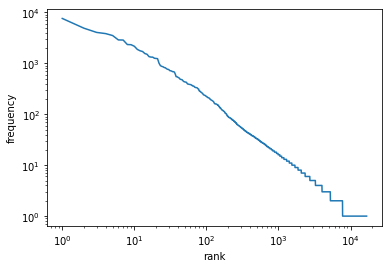

In [168]:
def plot_production_counts(pcount):
    counts = np.array([val for prod ,val in pcount.most_common()])
    # Fixing to start from index 1 instead of zero
    plt.loglog(np.arange(1, len(counts)+1), counts)
    plt.xlabel('rank')
    plt.ylabel('frequency')
plot_production_counts(pcount)

#### As we have seen before on many NLP datasets, the frequency of productions follows Zipf law

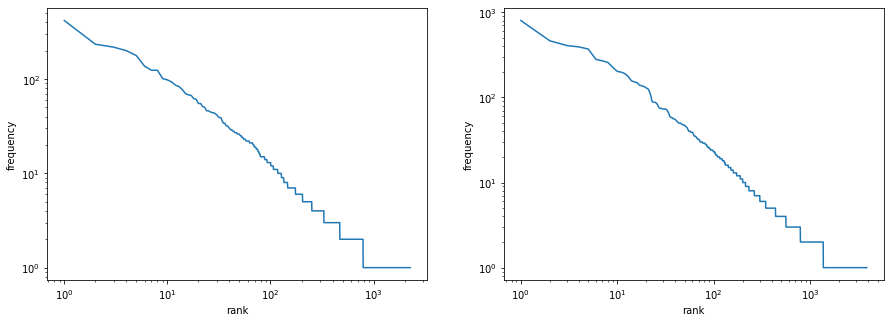

In [169]:
productions200 = list(get_productions(simplified_treebank, n=200))
pcount200 = productions_counts(productions200)
productions400 = list(get_productions(simplified_treebank, n=400, s=200))
pcount400 = productions_counts(productions400)

counts200 = np.array([val for prod ,val in pcount200.most_common()])
counts400 = np.array([val for prod ,val in pcount400.most_common()])
# Fixing to start from index 1 instead of zero
fig, axis = plt.subplots(1,2,figsize=(15,5))
axis[0].loglog(np.arange(1, len(counts200)+1), counts200)
axis[1].loglog(np.arange(1, len(counts400)+1), counts400)
for ax in axis.flat:
    ax.set(xlabel='rank', ylabel='frequency')

#### By learning from more trees, we see a similar trend, but the function is smoother.
#### We can't calculate KL Divergence without smoothing like Good Turing, since it is undefined if not all productions have positive probability on the second PCFG.
#### What we can do to guarantee that is using a subset of trees to learn:

In [170]:
pcfg200 = pcfg_learn(simplified_treebank, productions=productions200)
pcfg400 = pcfg_learn(simplified_treebank, n=400)
prob_dists200 = pcfg_to_prob_dist(pcfg200)
prob_dists400 = pcfg_to_prob_dist(pcfg400)
kl_divergence(prob_dists200, prob_dists400, printing=False)

11.404884807562855

#### The KL divergence is quite large, so we get very different models for 200 trees vs 400 trees, it means that we need between 400 to 1000 trees to learn a good model that generalize well (at least).

<a name="q2.3"></a>
<h3>Question 2.3: Induce a PCFG in Chomsky Normal Form</h3>

<a name="q2.3.1"></a>
<h4>2.3.1 PCFG_CNF_Learn</h4>

Implement <code>pcfg_cnf_learn</code>

We now want to learn a PCFG in Chomsky Normal Form from the treebank, with simplified tags, and with filtered NONE elements.
The strategy is to convert the trees in the treebank into CNF, then to induce the PCFG from the transformed trees.
Use the function <code>chomsky_normal_form</code> in <a href="http://www.nltk.org/_modules/nltk/treetransforms.html">nltk.treetransforms</a> to convert the trees.  
Pay attention to NONE filtering.  Use horizontal Markov annotation and parent annotation:

<code>
chomsky_normal_form(tree, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
</code>

<pre class="prettyprint">
pcfg_cnf_learn(treebank, n)
-- treebank is the nltk.corpus.treebank lazy corpus reader (simplified tags)
-- n indicates the number of trees to read
-- return an nltk.PCFG in CNF
</pre>

In [171]:
from nltk.treetransforms import chomsky_normal_form

def pcfg_cnf_learn(treebank, n=None, productions=None, s=0):
    cnf_treebank = []
    if productions is None:
        for tree in treebank[s:None if n==None else s+n]:
            tree = tree.copy(deep=True)
            simplify_tree(tree)
            chomsky_normal_form(tree, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
            cnf_treebank.append(tree)        
    productions = get_productions(cnf_treebank, n, s)
    return nltk.grammar.induce_pcfg(S, productions)

cnf_treebank = []
for tree in treebank:
    tree = tree.copy(deep=True)
    chomsky_normal_form(tree, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
    cnf_treebank.append(tree)

cnf_productions = list(get_productions(cnf_treebank))
cnf_pcfg = pcfg_learn(cnf_treebank, productions=cnf_productions)

In [172]:
assert set(len(p.rhs()) for p in cnf_productions)==set([1,2])
print("CNF conversion has worked!")

CNF conversion has worked!


<a name="q2.3.2"></a>
<h4>2.3.2 Data Exploration</h4>

How many productions are learned from the CNF trees? How many interior nodes were in the original treebank, and in the CNF treebank?

Compare the CNF and non-CNF figures (ratios).  What do you conclude?

In [173]:
cnf_pcount = productions_counts(cnf_productions)
print(f"For the CNF trees there are {len(cnf_pcount.keys())} productions from {sum(cnf_pcount.values())} interior nodes")
pcount = productions_counts(productions)
print(f"For the CNF trees there are {len(pcount.keys())} productions from {sum(pcount.values())} interior nodes")
print(f"The ratios are {len(cnf_pcount.keys())/len(pcount.keys())} and {sum(cnf_pcount.values())/sum(pcount.values())} accordingly")

For the CNF trees there are 19556 productions from 212068 interior nodes
For the CNF trees there are 16722 productions from 167545 interior nodes
The ratios are 1.16947733524698 and 1.2657375630427645 accordingly


#### We can conclude that about 1 in 4 productions had 3 or more productions, and when they were converted to CNF, they generated many new productions unseen on the original trees.

<a name="q2.4"></a>
<h3>Question 2.4: Test CFG Independence Assumptions</h3>

We want to test the CFG hypothesis that a node expansion is independent from its location within a tree.
<p/>

For the treebank before CNF transformation, report the following statistics, for the expansions of the NP category:
<ul>
<li>Compute the distribution of the RHS given the NP LHS for all NPs in the treebank.  Draw a histogram plot.
<li>Compute the same distribution only for NPs that appear directly below a S node (any variant of S in the Penn treebank tagset). Draw a histogram plot.
<li>Compute the same distribution only for NPs that appear directly below a VP node (any variant of VP in the Penn Treebank tagset). Draw a histogram plot. 
<li>Compare the distributions above.  Use KL-divergence.
<li>Conclude: does the data in the treebank confirm the CFG hypothesis for each configuration (original trees, annotated CNF trees)? 
    (How do you calibrate the values of the KL-divergence to decide that 2 values are similar?)
</ul>
<p/>


In [174]:
def get_top_N(p_dist, N):
    res = []
    samples = p_dist.samples()
    for x in samples:
        px = p_dist.prob(x)
        res.append((x,px))
    res.sort(key=lambda x: x[1], reverse=True)
    return res[:N]
        
prob_dists = pcfg_to_prob_dist(pcfg)

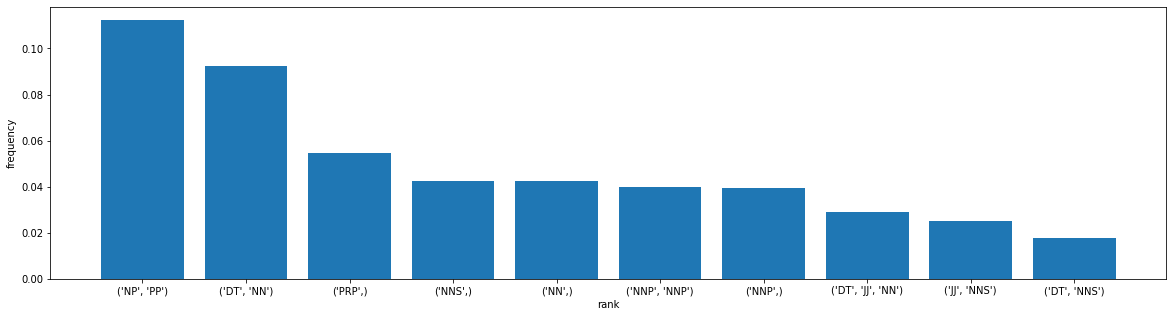

In [175]:
N=10
def plot_production_hist(data):
    labels = [str(x[0]) for x in data]
    values = [x[1] for x in data]
    plt.figure(figsize=(20,5))
    plt.bar(labels, values)
    plt.xlabel('rank')
    plt.ylabel('frequency')

NP = Nonterminal('NP')
VP = Nonterminal('NP')
top10_prob = get_top_N(prob_dists[NP], N)
plot_production_hist(top10_prob)

In [176]:
prob_dists.keys()

dict_keys([S, NP, NNP, ,, ADJP, CD, NNS, JJ, VP, MD, VB, DT, NN, PP, IN, ., VBZ, VBG, UCP, CC, VBD, VBN, RRC, ADVP, RB, TO, PRP, QP, RBR, SBAR, WHNP, WDT, VBP, PRT, RP, PRP$, JJS, POS, ``, EX, '', WP, SINV, :, JJR, NAC, WHADVP, WRB, PRN, $, FRAG, CONJP, NP=2, WHPP, NX, NNPS, WP$, , PDT, SBARQ, RBS, SQ, FW, INTJ, UH, SYM, X, LST, LS, #, ADVP|PRT, PP=3, ADVP=3, NP=3, VP=2, WHADJP])

In [177]:
def tree_to_productions(tree):
    yield tree_to_production(tree)
    for child in tree:
        if isinstance(child, Tree):
            for prod in tree_to_productions(child):
                yield prod

def get_filtered_productions(treebank, n=None, s=0, subtree_func=None, child_func=None):
    for tree in treebank[s:None if n==None else s+n]:
        for subtree in tree.subtrees():
            if subtree_func is not None and not subtree_func(subtree):
                continue
            for child in subtree:
                if isinstance(child, Tree):
                    if child_func is not None and not child_func(child):
                        continue
                    prod = tree_to_production(child)
                    if [prod.lhs()] != prod.rhs():
                        yield prod

                
s_productions = list(get_filtered_productions(simplified_treebank[3:4], 
                                            subtree_func=lambda x: x.label()==S,
                                            child_func=lambda x: x.label()=='NP'
                                           ))


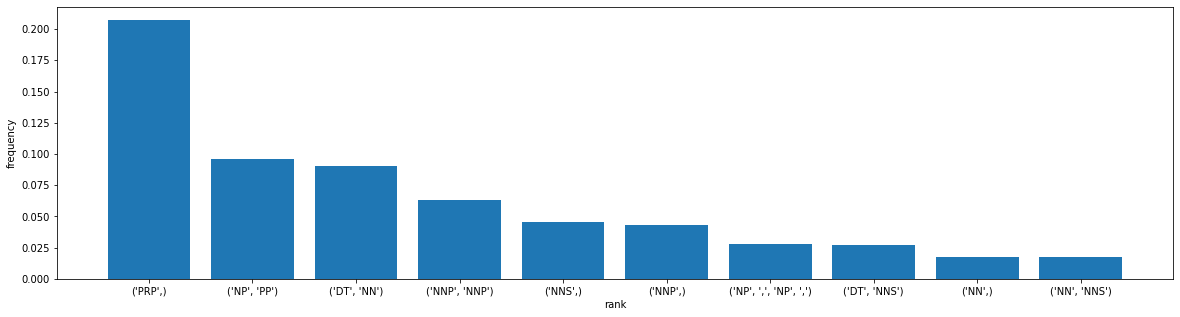

In [178]:
def plot_and_get_filtered_by_node(label='S'):
    s_productions = list(get_filtered_productions(simplified_treebank, 
                                            subtree_func=lambda x: x.label()==label,
                                            child_func=lambda x: x.label()=='NP'
                                           ))
    s_pcfg = pcfg_learn(treebank, productions=s_productions)
    s_prob_dists = pcfg_to_prob_dist(s_pcfg)
    s_top10_prob = get_top_N(s_prob_dists[NP], N)
    plot_production_hist(s_top10_prob)
    return s_prob_dists
s_prob_dists = plot_and_get_filtered_by_node()

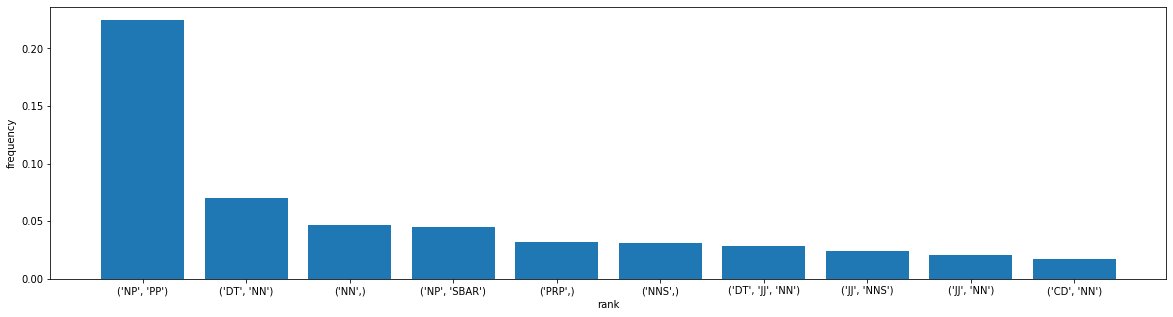

In [179]:
vp_prob_dists = plot_and_get_filtered_by_node('VP')

In [180]:
s_kl = kl_divergence(s_prob_dists, prob_dists, printing=False)
vp_kl = kl_divergence(vp_prob_dists, prob_dists, printing=False)
print(f"KL Divergence for only nodes below a 'S' node is {s_kl}")
print(f"KL Divergence for only nodes below a 'VP' node is {vp_kl}")

KL Divergence for only nodes below a 'S' node is 0.3952584303408347
KL Divergence for only nodes below a 'VP' node is 0.3226543663388717


### Let's try a randomized test to see the predicted scale of a random distribution

In [181]:
def get_random_distribuion(dist):
    n = len(dist.samples())
    rnd = np.random.random(n)
    sort = np.sort(rnd)
    diff = np.hstack((sort[0], np.diff(sort)))
    assert diff.shape[0] == n
    new_dist = {}
    for i, x in enumerate(dist.samples()):
        new_dist[x] = diff[i]
    return DictionaryProbDist(new_dist)

# random_kl_divergence = np.mean(
random_divergernces = [kl_divergence({NP: get_random_distribuion(prob_dists[NP])}, prob_dists, printing=False) for _ in range(100)]
avg = np.mean(random_divergernces)
std = np.std(random_divergernces)
print(f"For a random distribution we get an avergae KL Divergence of {avg} with std of {std}")

For a random distribution we get an avergae KL Divergence of 2.579521727167509 with std of 0.03669272831628316


In [182]:
print(f"Therefor the KL divergence for 'S' node is {abs(s_kl-avg)/std} standart deviations from the mean")
print(f"Therefor the KL divergence for 'VP' node is {abs(vp_kl-avg)/std} standart deviations from the mean")

Therefor the KL divergence for 'S' node is 59.52850597532051 standart deviations from the mean
Therefor the KL divergence for 'VP' node is 61.507210403514904 standart deviations from the mean


#### We get that the distributions for the specific condition are very very far from random distributions, therefor they are quite close to the original distribution.
#### Whether it's close enough is a question of the actual application.

<hr/>
<a name="q3"></a>
<h2>Question 3: Building and Evaluating a Simple PCFG Parser</h2>

In this question, we will construct a Viterbi parser for the PCFG induced in Question 2 and perform evaluation of this statistical parser. 
<p/>

<a name="q3.1"></a>
<h3>Question 3.1: Build a Parser</h3>

<a name="q3.1.1"></a>
<h4>3.1.1 Dataset Split</h4>
    
Split the NLTK treebank corpus into 80% training (about 3,200 trees) and 20% (about 800 trees) testing sets.
<p/>

In [183]:
# treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
# treebank = treebank.parsed_sents()

cutoff = int(len(treebank)*0.8)
train, test = simplified_treebank[:cutoff], treebank[cutoff:]

<a name="q3.1.2"></a>
<h4>3.1.2 Learn a PCFG over the Chomsky Normal Form version of this treebank</h4>
<p/>

#### We should handle unknown words to be able to use viterbi parser. Let's first see how many words we have on the train dataset.
#### Another option was to use smoothing (but smoothing for infinite number of unknown words should be done very carefully to sum up all probabilities to 1, and there doesn't seem to be a simple way of doint that with PCFG).

In [184]:
import itertools
print(f"We have {len(set(itertools.chain(*[[x.lower() for x in tree.leaves()] for tree in train])))} different words") 

We have 9711 different words


#### Let's take the top 1000 of them (this could be a hyper-parameter for the model of course)

In [185]:
from collections import Counter
c = Counter(itertools.chain(*[[x.lower() for x in tree.leaves()] for tree in simplified_treebank[:cutoff]]))
most_common = set([x[0] for x in c.most_common(1000)])
print(f"We cover {len(list(itertools.chain(*[[x.lower() for x in tree.leaves() if x.lower() in most_common] for tree in train])))} out of {len(list(itertools.chain(*[[x.lower() for x in tree.leaves()] for tree in train])))} tokens") 

We cover 56768 out of 75385 tokens


In [186]:
c.most_common(5)

[(',', 3955), ('the', 3841), ('.', 3068), ('of', 1854), ('to', 1718)]

#### We will now handle unknown words. Let's first see how many words we have on the train corpus:
#### Another option was to use smoothing (but smoothing for infinite number of unknown words should be done very carefully to sum up all probabilities to 1, and there doesn't seem to be a simple way of doint that with PCFG

In [44]:
import itertools
print(f"We have {len(set(itertools.chain(*[[x.lower() for x in tree.leaves()] for tree in simplified_treebank[:cutoff]])))} different words") 

We have 9711 different words


#### Let's take the top 1000 of them (this could be a hyper-parameter for the model of course)

In [49]:
from collections import Counter
c = Counter(itertools.chain(*[[x.lower() for x in tree.leaves()] for tree in simplified_treebank[:cutoff]]))
most_common = set([x[0] for x in c.most_common(1000)])
print(f"We cover {len(list(itertools.chain(*[[x.lower() for x in tree.leaves() if x.lower() in most_common] for tree in simplified_treebank[:cutoff]])))} out of {len(list(itertools.chain(*[[x.lower() for x in tree.leaves()] for tree in simplified_treebank[:cutoff]])))} tokens") 

We cover 56768 out of 75385 tokens


#### Let's now change the trees, the way we did with the none subtrees

In [241]:
UNKOWN = '<UNK>'
def replace_trees_rare_words(treebank, known_words):
    for tree in treebank:
        for position in tree.treepositions('leaves'):
            if tree[position].lower() in known_words:
                tree[position] = tree[position].lower()
            else:
                tree[position] = UNKOWN
    return treebank


for tree in test[0:1]:
    sentence = tree.leaves()
    print(sentence)
    sentence = replace_sentences_rare_words([sentence], most_common)
    print(sentence)

['The', 'latest', '10-year', 'notes', 'were', 'quoted', 'at', '100', '22\\/32', '*-1', 'to', 'yield', '7.88', '%', 'compared', 'with', '100', '16\\/32', '*', 'to', 'yield', '7.90', '%', '.']
[['the', 'latest', '<UNK>', 'notes', 'were', '<UNK>', 'at', '100', '<UNK>', '<UNK>', 'to', 'yield', '<UNK>', '%', 'compared', 'with', '100', '<UNK>', '<UNK>', 'to', 'yield', '<UNK>', '%', '.']]


#### Let's change the sentences accordingly too

In [242]:
def replace_sentences_rare_words(sentences, known_words):
    res = [None] * len(sentences)
    for j, s in enumerate(sentences):
        for i, token in enumerate(s):
            s[i] = token.lower()
            if s[i] not in known_words:
                s[i] = UNKOWN
        res[j] = s
    return res

#### We are now ready to learn a PCFG

In [227]:
from nltk import ViterbiParser
train = replace_trees_rare_words(train, most_common)
train_pcfg = pcfg_cnf_learn(train)
assert len(train_pcfg.productions()) > 0


In [228]:
train_pcfg.productions()[0]

S -> NP S|<VP> [0.326765]

#### Let's confirm that we get Nonterminals as the rhs of the production

In [229]:
set(type(p.rhs()[0]) for p in train_pcfg.productions() if len(p.rhs())==1)

{nltk.grammar.Nonterminal, str}

<a name="q3.1.3"></a>
<h4>3.1.3 Viterbi Parser</h4>
    
Construct a <code><a href="https://www.nltk.org/_modules/nltk/parse/viterbi.html">ViterbiParser</a></code> using this PCFG grammar.
Test the parser on a few sentences.

#### Something in the transformation of the tree we did earlier makes the parser unable to work properly (even though the data does seem fine...)
#### We will rewrite the code, so that it won't actually replace the tags as asked on previous questions, only change then for the PFCG.

In [199]:
from nltk.grammar import Production
from nltk import Tree, Nonterminal

def simplify_functional_tag(tag):
    if '-' in tag:
        tag = tag.split('-')[0]
    return tag

def get_tag(tree):
    if isinstance(tree, Tree):
        return Nonterminal(simplify_functional_tag(tree.label()))
    else:
        return tree

def tree_to_production(tree):
    return Production(get_tag(tree), [get_tag(child) for child in tree])

def tree_to_productions(tree):
    yield tree_to_production(tree)
    for child in tree:
        if isinstance(child, Tree):
            for prod in tree_to_productions(child):
                yield prod
                
def simplify_tree(tree):
    to_del = []
    for subtree in tree.subtrees():       
        for i, child in enumerate(subtree):
            if isinstance(child, str):
                continue
            if len(list(child.subtrees(filter=lambda x:x.label()=='-NONE-')))==len(child.leaves()):
                to_del.append((subtree, i))
    to_del.reverse()
    for subtree, i in to_del:
        del subtree[i]

def get_simplified_trees(treebank, n=None, s=0):
    for tree in treebank[s:None if n==None else s+n]:
        tree = tree.copy(deep=True)
        simplify_tree(tree)
        assert tree is not None
        yield tree
                
def get_productions(treebank, n=None, s=0):
    for tree in treebank[s:None if n==None else s+n]:
        for prod in tree_to_productions(tree):
            if [prod.lhs()] != prod.rhs():
                yield prod

def pcfg_learn(treebank, n=None, productions=None, s=0):
    if productions is None:
        productions = get_productions(treebank, n, s)
    return nltk.grammar.induce_pcfg(S, productions)

treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
treebank = treebank.parsed_sents()
non_none_treebank = list(get_simplified_trees(treebank))
train = non_none_treebank[:cutoff]
train = replace_trees_rare_words(train, most_common)
train_pcfg = pcfg_cnf_learn(train)
assert len(train_pcfg.productions()) > 0

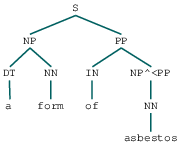

In [205]:
from nltk.parse import ViterbiParser

parser = ViterbiParser(train_pcfg)

# Sanity check
parser.parse_one('a form of asbestos'.split(' '))

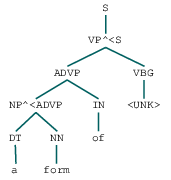

In [269]:
#Unkown words sanity check
parser.parse_one('a form of <UNK>'.split(' '))

<a name="q3.2"></a>
<h3>Question 3.2: Evaluate the Parser</h3>

Your task is to compute the ParsEval metric for the constituent-based parse trees on the test dataset of our treebank.  
Report the following metrics:
<ol>
<li>Precision
<li>Recall
<li>F-measure
<li>Labelled Precision
<li>Labelled Recall
<li>Labelled F-Measure
</ol>

Where precision and recall are computed over "constituents" between the parsed trees and the treebank trees: a constituent is a triplet 
(interior_node, first_index, last_index) - where first_index is the index of the first word in the sentence covered by the interior node,
and last_index that of the last word (that is, [first_index, last_index] is the yield of the interior node).
<p/>

In labelled precision and recall we count that 2 constituents match if they have the same label for the interior node.  
For unlabelled metrics, we just compare the first and last indexes.  
Make sure you compare the trees from the treebank after they have been simplified: for example, S-TPC-1 must be compared with S and ADVP-TMP with ADVP, and -NONE- nodes have been eliminated.
<p/>

You can read more on this metric in the following references:
<ol>
<li><a href="http://courses.washington.edu/ling571/ling571_fall_2010/slides/evalb_improved_pcky.pdf">An assignment on parsing evaluation by Scott Farrar</a> includes detailed explanation and examples on how the metric is computed.
<li><a href="http://nlp.cs.nyu.edu/evalb/">Evalb</a> software: this is the C program used in all standard evaluations of constituent parsers (by Satoshi Sekine and Michael  Collins).
<li><a href="http://nlp.stanford.edu/nlp/javadoc/javanlp/edu/stanford/nlp/parser/metrics/Evalb.html">Evalb in Java</a> for those who prefer reading Java over C - is part of the Stanford CoreNLP package.
</ol>

The specific steps to follow are:
<ul>
<li>Generate a list of labelled constituents of the form <code>[label first_index last_index]</code> given a parse tree.</li>
<li>Compute unlabelled Precision, Recall and F-measure for your parser on the test dataset</li>
<li>Compute labelled Precision, Recall and F-measure for your parser on the test dataset</li>
</ul>

In [265]:
import re
label_regex = re.compile('[A-Za-z]+')
def simple_label(s):
    res = label_regex.match(s)
    if res:
        return res[0]
    return s

def get_constituents(tree):
    res = []
    i = 0
    for subtree in tree.treepositions():
        if isinstance(tree[subtree], Tree):
            res.append((simple_label(tree[subtree].label()), i, i + len(tree[subtree].leaves())))
        else:
            i += 1
    return res    

test[0].pprint()
get_constituents(test[0])

(S
  (NP-SBJ-1 (DT The) (JJS latest) (JJ 10-year) (NNS notes))
  (VP
    (VBD were)
    (VP
      (VBN quoted)
      (PP-CLR (IN at) (NP (CD 100) (CD 22\/32)))
      (S-CLR
        (NP-SBJ (-NONE- *-1))
        (VP (TO to) (VP (VB yield) (NP (CD 7.88) (NN %)))))
      (PP
        (VBN compared)
        (PP
          (IN with)
          (NP
            (NP (CD 100) (CD 16\/32))
            (S-CLR
              (NP-SBJ (-NONE- *))
              (VP (TO to) (VP (VB yield) (NP (CD 7.90) (NN %))))))))))
  (. .))


[('S', 0, 24),
 ('NP', 0, 4),
 ('DT', 0, 1),
 ('JJS', 1, 2),
 ('JJ', 2, 3),
 ('NNS', 3, 4),
 ('VP', 4, 23),
 ('VBD', 4, 5),
 ('VP', 5, 23),
 ('VBN', 5, 6),
 ('PP', 6, 9),
 ('IN', 6, 7),
 ('NP', 7, 9),
 ('CD', 7, 8),
 ('CD', 8, 9),
 ('S', 9, 14),
 ('NP', 9, 10),
 ('-NONE-', 9, 10),
 ('VP', 10, 14),
 ('TO', 10, 11),
 ('VP', 11, 14),
 ('VB', 11, 12),
 ('NP', 12, 14),
 ('CD', 12, 13),
 ('NN', 13, 14),
 ('PP', 14, 23),
 ('VBN', 14, 15),
 ('PP', 15, 23),
 ('IN', 15, 16),
 ('NP', 16, 23),
 ('NP', 16, 18),
 ('CD', 16, 17),
 ('CD', 17, 18),
 ('S', 18, 23),
 ('NP', 18, 19),
 ('-NONE-', 18, 19),
 ('VP', 19, 23),
 ('TO', 19, 20),
 ('VP', 20, 23),
 ('VB', 20, 21),
 ('NP', 21, 23),
 ('CD', 21, 22),
 ('NN', 22, 23),
 ('.', 23, 24)]

In [266]:
sentences = [tree.leaves() for tree in test]
print(sentences[0][:5])
replace_sentences_rare_words(sentences, most_common)
print(sentences[0][:5])

['The', 'latest', '10-year', 'notes', 'were']
['the', 'latest', '<UNK>', 'notes', 'were']


#### We must use multiprocessing to finish the parsing in a somewhat reasonable time.
#### We run into a power failure and lost the results we got.
#### We will add pickle in the middle in order not to lose too much data in case of another failure (it's a good practice!).
#### We can send the full results until 4.2 if that's alright, but we have ran the next questions on partial test data for completness anyway.

In [ ]:
import multiprocessing
import functools
import pickle
SIZE = 100
if __name__ ==  '__main__':
    all_pred = []
    partial = functools.partial(parser.parse_one)
    for i in range(0,len(sentences),SIZE):
        with multiprocessing.Pool(7) as pool:
            pred = pool.map(partial, sentences[i:i+SIZE])
            all_pred.extend(pred)
            with open(f'../output/predicted_trees_{i}_{i+100-1}.pickle', 'wb') as f:
                pickle.dump([tree.pformat() for tree in pred], f)

In [304]:
constituents = [get_constituents(tree) for tree in test]
constituents_pred = [get_constituents(tree) if tree else None for tree in all_pred]
print(constituents_pred[1])

[('S', 0, 32), ('NP', 0, 7), ('NP', 0, 3), ('DT', 0, 1), ('NP', 1, 3), ('JJ', 1, 2), ('NN', 2, 3), ('PP', 3, 7), ('IN', 3, 4), ('NP', 4, 7), ('NNP', 4, 5), ('NP', 5, 7), ('NNP', 5, 6), ('NNS', 6, 7), ('S', 7, 32), ('VP', 7, 31), ('VBD', 7, 8), ('VP', 8, 31), ('NP', 8, 13), ('NP', 8, 10), ('JJ', 8, 9), ('NNS', 9, 10), ('PP', 10, 13), ('IN', 10, 11), ('NP', 11, 13), ('JJ', 11, 12), ('NN', 12, 13), ('VP', 13, 31), (',', 13, 14), ('SBAR', 14, 31), ('IN', 14, 15), ('S', 15, 31), ('NP', 15, 20), ('NP', 15, 17), ('DT', 15, 16), ('NN', 16, 17), ('PP', 17, 20), ('IN', 17, 18), ('NP', 18, 20), ('JJ', 18, 19), ('NNS', 19, 20), ('VP', 20, 31), ('VBD', 20, 21), ('VP', 21, 31), ('VB', 21, 22), ('NP', 22, 31), ('NP', 22, 26), ('QP', 22, 25), ('JJR', 22, 23), ('QP', 23, 25), ('IN', 23, 24), ('CD', 24, 25), ('NN', 25, 26), ('VP', 26, 31), ('VBN', 26, 27), ('PP', 27, 31), ('IN', 27, 28), ('NP', 28, 31), ('JJ', 28, 29), ('NP', 29, 31), ('NN', 29, 30), ('NNP', 30, 31), ('.', 31, 32)]


In [297]:
def get_correct_numpred_numtrue(constituents, constituents_pred, func=lambda x: x, filter_func=lambda x: True):
    constituents = [func(x) for x in constituents if filter_func(x)]
    constituents_pred = set(func(x) for x in constituents_pred if filter_func(x))
    correct = len(list(c for c in constituents if c in constituents_pred))
    return correct, len(constituents_pred), len(constituents)


def get_precision_recall_f1(constituents, constituents_pred, func=lambda x: x, filter_func=lambda x: True):
    results = [get_correct_numpred_numtrue(c, cp, func, filter_func) for c, cp in zip(constituents, constituents_pred)]
    correct = sum(x[0] for x in results)
    num_pred = sum(x[1] for x in results)
    num_true = sum(x[2] for x in results)
    presicion = correct/num_true if num_true else float('nan')
    recall = correct/num_pred if num_pred else float('nan')
    f1 = 2*presicion*recall/(presicion+recall) if presicion+recall else float('nan')
    return presicion, recall, f1 
u_presicion, u_recall, u_f1 = get_precision_recall_f1(constituents, constituents_pred, func=lambda x:x[1:])
l_presicion, l_recall, l_f1 = get_precision_recall_f1(constituents, constituents_pred)
print(f"1. Unlabled precision is {u_presicion}")
print(f"2. Unlabled recall is {u_recall}")
print(f"3. Unlabled f1 is {u_f1}")
print(f"4. Labled precision is {l_presicion}")
print(f"5. Labled recall is {l_recall}")
print(f"6. Labled f1 is {l_f1}")

1. Unlabled precision is 0.9213709677419355
2. Unlabled recall is 0.817531305903399
3. Unlabled f1 is 0.866350710900474
4. Labled precision is 0.7137096774193549
5. Labled recall is 0.6135181975736569
6. Labled f1 is 0.6598322460391426


<a name="q3.3"></a>
<h3>Question 3.3: Accuracy per Distance</h3>

In general, parsers do a much better job on short constituents than long ones.  
Draw a plot of the accuracy of constituents per constituent length.  
The length of a constituent (node, first, last) is last-first+1.  
For a given constituent length X, accuracy is the number of constituents 
of length X in the parsed tree that are accurate divided by the total number of constituents of length X.

Text(0, 0.5, 'accuracy')

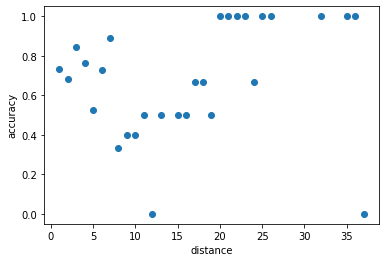

In [298]:
def dist_func(x):
    return x[2] - x[1]
distances = list(set(dist_func(x) for c in constituents for x in c))
accuracy_per_distance = []
for d in distances:
    d_presicion, _, _ = get_precision_recall_f1(constituents, constituents_pred, filter_func=lambda x: dist_func(x)==d)
    accuracy_per_distance.append(d_presicion)
plt.scatter(distances, accuracy_per_distance)
plt.xlabel('distance')
plt.ylabel('accuracy')

<a name="q3.4"></a>
<h3>Question 3.4: Accuracy per Label</h3>

Report accuracy of constituents per label type (S, SBAR, NP, VP, PP etc).
For each node type, report number of occurrences and accuracy. 
Note: report accuracy per node type WITHOUT Chomsky Normal Form modification.
For example, if the CNF of the tree generated a non-terminal NP^S, we should count this as NP for this question.

Text(0, 0.5, 'accuracy')

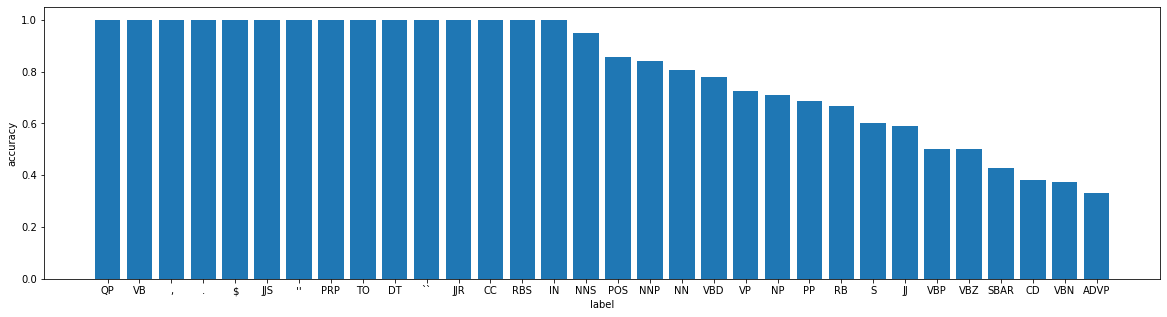

In [334]:
def label_func(x):
    return x[0]
labels = list(set(label_func(x) for c in constituents for x in c))
accuracy_per_label = []
for l in labels:
    l_presicion, _, _ = get_precision_recall_f1(constituents, constituents_pred, filter_func=lambda x: label_func(x)==l)
    accuracy_per_label.append(l_presicion)

zipped = list(zip(labels, accuracy_per_label))
zipped = [x for x in zipped if x[1]>0]
zipped.sort(key=lambda x: x[1], reverse=True)
labels = [x[0] for x in zipped]
accuracy_per_label = [x[1] for x in zipped]
plt.figure(figsize=(20,5))
plt.bar(labels[:50], accuracy_per_label[:50])
plt.xlabel('label')
plt.ylabel('accuracy')

END